In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.signal import welch
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
freqs_true = np.arange(2,100,5)
sr = 1000
t = np.arange(5000)
max_amp = 1
power = -2.

nets = []
phi_as = []
phi_ps = []
freq_amps = []
F_trues = []
for f in freqs_true:
    phi_a = np.random.rand(100) + 0.5
    phi_a = phi_a / np.sum(phi_a**2, axis=0)**0.5
    phi_p = np.random.randint(-50,50,size=100)
    freq_amp = np.ones(len(t)) * max_amp * f**power
    net, F_true, _ = utils.make_network(f, len(t), phi_a, phi_p, time_mod=freq_amp)
    nets.append(net)
    phi_as.append(phi_a)
    phi_ps.append(phi_p)
    freq_amps.append(freq_amp)
    F_trues.append(F_true)
nets = np.array(nets)
phi_as = np.array(phi_as)
phi_ps = np.array(phi_ps)
freq_amps = np.array(freq_amps)
F_trues = np.array(F_trues)

x = np.sum(nets, axis=0)
x = utils.add_noise(x, std=0.001, freq_scaling=-2.5)
t = np.arange(x.shape[1]) / sr
t = t - t[1500]

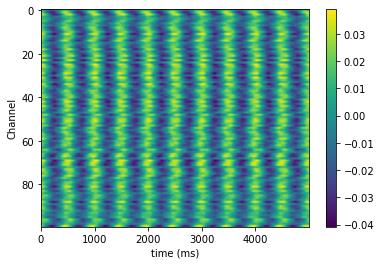

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.xlabel('time (ms)')
plt.ylabel('Channel')
plt.savefig('recentImage')

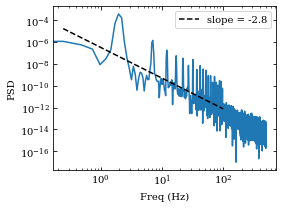

In [7]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

psd_f, psd_p = welch(x[0], fs=sr, nperseg = 4096)
psd_ff = psd_f.copy()[psd_f<=100][1:]
psd_pp = psd_p.copy()[psd_f<=100][1:]
slope, intercept, _, _, _ = scipy.stats.linregress(np.log(psd_ff), np.log(psd_pp))
ax.loglog(psd_f, psd_p)
ax.plot(psd_ff, np.exp(intercept)*(psd_ff**slope), color='black', linestyle='dashed', \
         label='slope = '+str(np.round(slope,1)))
# plt.loglog(freqs_true, freq_amps[:,0])
ax.legend()
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('PSD')
plt.savefig('figs/power_psd.svg', bbox_inches='tight')

In [8]:
bp_ranges = [[i,i+5] for i in np.arange(1,100,5)]

model = nsdmd.NSDMD(opt_rank=4, opt_stride=100, sim_thresh_phi_amp=0.9, verbose=True, \
                    bandpass = bp_ranges, bandpass_trim=1500, feature_seq_method='SFS', feature_final_num=30,\
                    feature_f_method='grad', feature_init=0.4, \
                    grad_alpha=0, grad_beta=0, grad_lr=0.01, grad_N=30)

In [9]:
model.fit_opt(x, t, sr)
x = x[:,1500:-1500]
t = t[1500:-1500]

Starting OPT-DMD...
Starting bandpass freq: 1 - 6 Hz
Starting bandpass freq: 6 - 11 Hz
Starting bandpass freq: 11 - 16 Hz
Starting bandpass freq: 16 - 21 Hz
Starting bandpass freq: 21 - 26 Hz
Starting bandpass freq: 26 - 31 Hz
Starting bandpass freq: 31 - 36 Hz
Starting bandpass freq: 36 - 41 Hz
Starting bandpass freq: 41 - 46 Hz
Starting bandpass freq: 46 - 51 Hz
Starting bandpass freq: 51 - 56 Hz
Starting bandpass freq: 56 - 61 Hz
Starting bandpass freq: 61 - 66 Hz
Starting bandpass freq: 66 - 71 Hz
Starting bandpass freq: 71 - 76 Hz
Starting bandpass freq: 76 - 81 Hz
Starting bandpass freq: 81 - 86 Hz
Starting bandpass freq: 86 - 91 Hz
Starting bandpass freq: 91 - 96 Hz
Starting bandpass freq: 96 - 101 Hz


Text(0.5, 1.0, 'Similar Solutions')

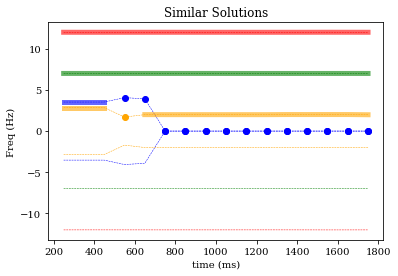

In [10]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx))[:8]:
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')
plt.title('Similar Solutions')

In [11]:
model.fit_reduction(x, len(t), sr)

Gathering modes...
Found 88 modes
Initially reducing to 25 modes

Number of modes: 1/25, stopping at 25
Number of modes: 2/25, stopping at 25
Number of modes: 3/25, stopping at 25
Number of modes: 4/25, stopping at 25
Number of modes: 5/25, stopping at 25
Number of modes: 6/25, stopping at 25
Number of modes: 7/25, stopping at 25
Number of modes: 8/25, stopping at 25
Number of modes: 9/25, stopping at 25
Number of modes: 10/25, stopping at 25
Number of modes: 11/25, stopping at 25
Number of modes: 12/25, stopping at 25
Number of modes: 13/25, stopping at 25
Number of modes: 14/25, stopping at 25
Number of modes: 15/25, stopping at 25
Number of modes: 16/25, stopping at 25
Number of modes: 17/25, stopping at 25
Number of modes: 18/25, stopping at 25
Number of modes: 19/25, stopping at 25
Number of modes: 20/25, stopping at 25
Number of modes: 21/25, stopping at 25
Number of modes: 22/25, stopping at 25
Number of modes: 23/25, stopping at 25
Number of modes: 24/25, stopping at 25
Number 

Text(0, 0.5, 'Cosine Distance')

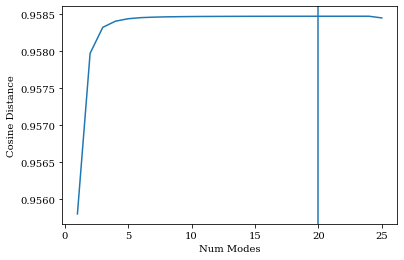

In [12]:
plt.plot(model.num_modes_, model.errors_)
plt.axvline(20)
plt.xlabel('Num Modes')
plt.ylabel('Cosine Distance')

In [13]:
model.fit_f(x, len(t), sr, 20)

In [14]:
f_hat_ = model.f_hat_[:,500:-500]
f_power_ = np.mean(f_hat_, axis=1)
f_hat_ = f_hat_ / f_power_[:,None]

idx = np.argsort(model.freq_mean_)
freq_mean_ = model.freq_mean_[idx]
f_hat_ = f_hat_[idx]
f_power_ = f_power_[idx]

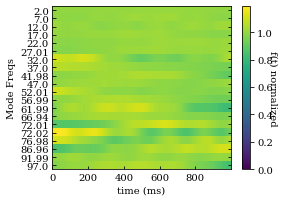

In [17]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

alpha = [str(np.round(f,2)) for f in freq_mean_]
cax = ax.matshow(f_hat_, aspect='auto', vmin=0)
cbar = fig.colorbar(cax)
cbar.set_label('f(t) normalized', rotation=270)
ax.set_yticks(np.arange(len(f_hat_)))
ax.set_yticklabels(alpha)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mode Freqs')
plt.savefig('figs/power_f_norm.svg', bbox_inches='tight')

Text(0, 0.5, 'f(t) (normalized)')

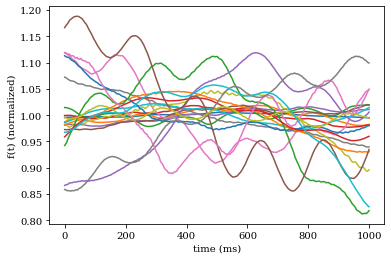

In [18]:
for f in f_hat_:
    plt.plot(f)
plt.xlabel('time (ms)')
plt.ylabel('f(t) (normalized)')

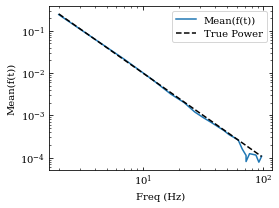

In [20]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

ax.loglog(freq_mean_, f_power_, label='Mean(f(t))')
ax.loglog(freqs_true, freq_amps[:,0],\
           color='black', linestyle='dashed', label='True Power')
ax.legend()
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Mean(f(t))')
plt.savefig('figs/power_psd_final.svg', bbox_inches='tight')

In [16]:
x_rec = model.transform(x, len(t), sr)

Text(0, 0.5, 'Channel')

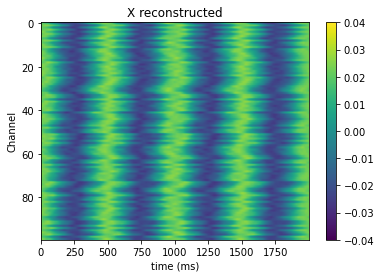

In [17]:
plt.imshow(x_rec, aspect='auto', vmin=-0.04, vmax=0.04)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

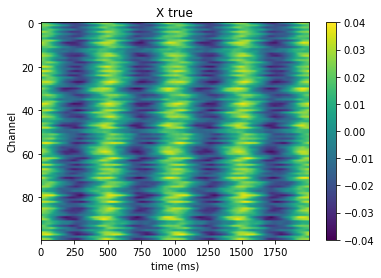

In [18]:
plt.imshow(x, aspect='auto', vmin=-0.04, vmax=0.04)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')